In [37]:
library(grf)
library(ggplot2)

In [38]:
data.all = read.csv("../grf_experiments/acic18/synthetic_data.csv")
data.all$schoolid = factor(data.all$schoolid)
df = data.all[,-1]
school.id = as.numeric(data.all$schoolid)

In [39]:
fractionTraining <- 0.50
fractionTest <- 0.50
sampleSizeTraining <- floor(fractionTraining*nrow(df))
sampleSizeTest <- floor(fractionTest*nrow(df))
indicesTraining <- sort(sample(seq_len(nrow(df)), size=sampleSizeTraining))
indicesTest <- setdiff(seq_len(nrow(df)), indicesTraining)
df_train <- df[indicesTraining, ]
df_test <- df[indicesTest, ]
school.id.train = school.id[indicesTraining]
school.id.test = school.id[indicesTest]

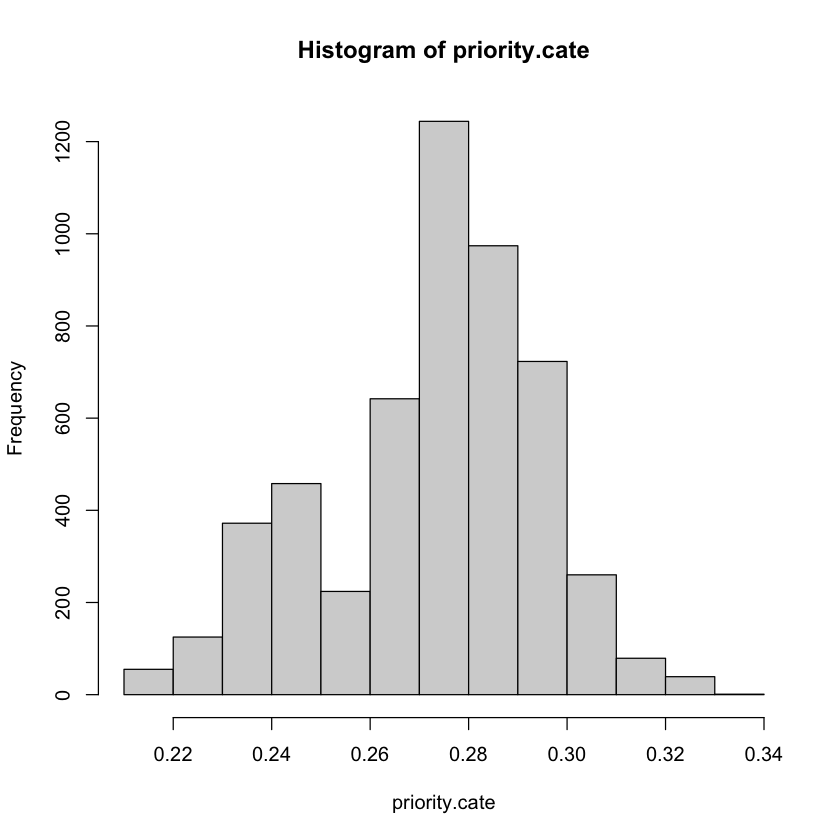

In [40]:
X = df_train[,-(1:2)]
Y = df_train$Y
W = df_train$Z

X_test = df_test[,-(1:2)]
Y_test = df_test$Y
W_test = df_test$Z

Y.forest = regression_forest(X, Y, clusters = school.id.train, equalize.cluster.weights = TRUE)
Y.hat = predict(Y.forest)$predictions
W.forest = regression_forest(X, W, clusters = school.id.train, equalize.cluster.weights = TRUE)
W.hat = predict(W.forest)$predictions

cf.raw = causal_forest(X, Y, W,
                       Y.hat = Y.hat, W.hat = W.hat,
                       clusters = school.id.train,
                       equalize.cluster.weights = TRUE)
varimp = variable_importance(cf.raw)
selected.idx = which(varimp > mean(varimp))

cf.priority = causal_forest(X[,selected.idx], Y, W,
                   Y.hat = Y.hat, W.hat = W.hat,
                   clusters = school.id.train,
                   equalize.cluster.weights = TRUE,
                   tune.parameters = "all")

priority.cate = predict(cf.priority,X_test[,selected.idx])$predictions
hist(priority.cate)

   estimate    std.err             target
 0.08827749 0.04990644 priorities | AUTOC

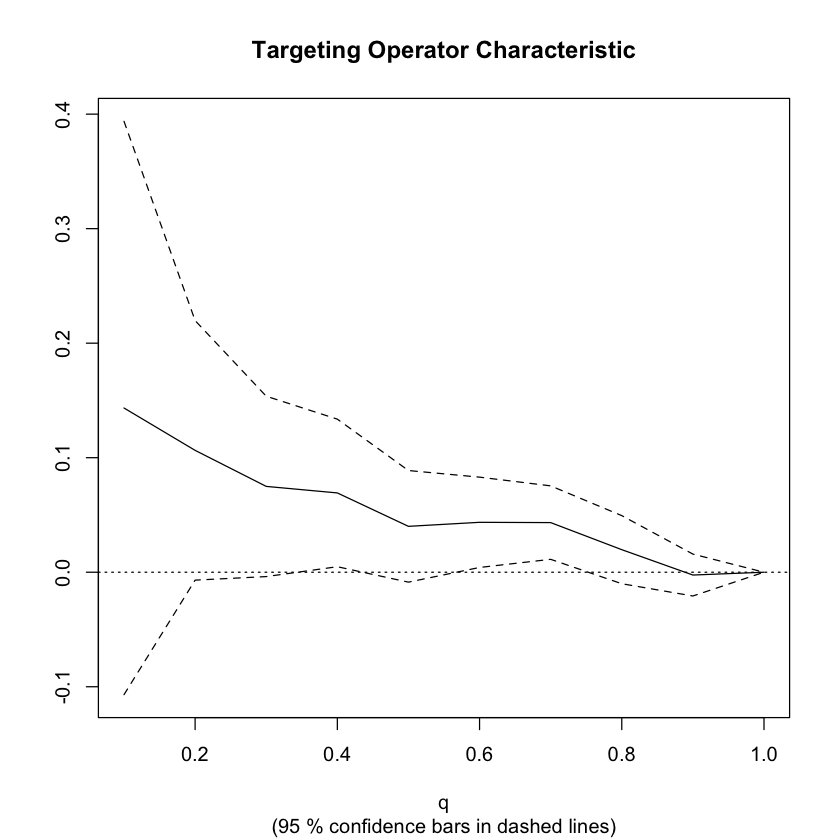

In [41]:
Y.forest = regression_forest(X_test, Y_test, clusters = school.id.test, equalize.cluster.weights = TRUE)
Y.hat = predict(Y.forest)$predictions
W.forest = regression_forest(X_test, W_test, clusters = school.id.test, equalize.cluster.weights = TRUE)
W.hat = predict(W.forest)$predictions

cf.raw = causal_forest(X_test, Y_test, W_test,
                       Y.hat = Y.hat, W.hat = W.hat,
                       clusters = school.id.test,
                       equalize.cluster.weights = TRUE)
varimp = variable_importance(cf.raw)
selected.idx = which(varimp > mean(varimp))

cf.eval = causal_forest(X_test[,selected.idx], Y_test, W_test,
                   Y.hat = Y.hat, W.hat = W.hat,
                   clusters = school.id.test,
                   equalize.cluster.weights = TRUE,
                   tune.parameters = "all")

rate <- rank_average_treatment_effect(cf.eval, priority.cate)
rate
plot(rate)